In [22]:
# !pip3 install lightgbm

In [23]:
# !pip3 install sktime

# LighGBM with linear-trees for Forecasting
12 April 2024

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

import re
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from lightgbm import plot_tree
import shap

In [4]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

# Output a pandas df intead of numpy
set_config(transform_output="pandas")

In [5]:
# Functions
def c_mape(y: pd.Series, y_hat: pd.Series) -> np.float64:
    """
    Implements Mean Absolute Percent Error (MAPE).
    Args:
        y: actual values.
        y_hat: predicted values.
    Returns:
        MAPE value (Not in %)
    """
    if not (isinstance(y, pd.Series) and isinstance(y_hat, pd.Series)):
        y, y_hat = pd.Series(y), pd.Series(y_hat)
    mape = np.mean(np.abs((y - y_hat) / y))
    return np.round(mape, 4)

## 1) Input data

In [6]:
data = pd.read_csv(
    "example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

data

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


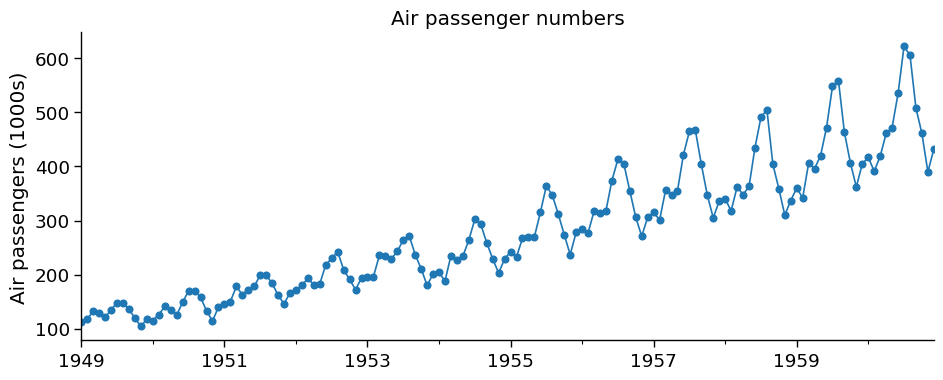

In [24]:
data.plot(y="y", marker="o", figsize=[11, 4], legend=None)

plt.ylabel("Air passengers (1000s)")
plt.xlabel("")
plt.title("Air passenger numbers")

plt.show()

In [8]:
# Create a copy of the data
df = data.copy(deep=True)
# Target
target = ["y"]

## 2) Feature Engineering

In [9]:
# Prepare time feature transformer.
time_feats = make_pipeline(
    TimeSince(freq="MS"),
    PolynomialFeatures(degree=3, include_bias=False)
)

# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 12],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

# Create features derived independent of one another
pipeline = make_union(
    time_feats,
    lag_window_feats
)

# MixMax scaler
pipeline = make_pipeline(pipeline, MinMaxScaler())
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince(freq='MS')),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=3,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 12], 'mean': [[1, 12]]},
                 target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [10]:
# Let's explore our pipeline
pipeline.fit_transform(df)

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,time_since_1949-01-01 00:00:00^3,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12
ds,,,,,,,,
1949-01-01,0.0000,0.0000,0.0000,0.0154,0.0154,0.0154,0.0176,0.0000
1949-02-01,0.0070,0.0000,0.0000,0.0154,0.0154,0.0154,0.0176,0.0000
1949-03-01,0.0140,0.0002,0.0000,0.0270,0.0154,0.0154,0.0176,0.0000
1949-04-01,0.0210,0.0004,0.0000,0.0541,0.0270,0.0154,0.0176,0.0000
1949-05-01,0.0280,0.0008,0.0000,0.0483,0.0541,0.0270,0.0176,0.0000
...,...,...,...,...,...,...,...,...
1960-08-01,0.9720,0.9448,0.9184,1.0000,0.8320,0.7104,1.0000,0.9582
1960-09-01,0.9790,0.9585,0.9384,0.9691,1.0000,0.8320,0.7890,0.9695
1960-10-01,0.9860,0.9722,0.9586,0.7799,0.9691,1.0000,0.6659,0.9803


In [11]:
# We can use `clone` to return an unfitted version of the pipeline.
pipeline = clone(pipeline)

## 3) Recursive Forecast

In [12]:
# Define time of first forecast, this determines our train / test split
forecast_start_time = pd.to_datetime("1958-01-01")

# Horizon
num_of_forecast_steps = 36

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="MS"
)

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(months=12)

### 3.1) Train/Test split

In [13]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

X_train.head()

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,time_since_1949-01-01 00:00:00^3,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12
ds,,,,,,,,
1949-01-01,0.0000,0.0000,0.0000,0.0220,0.0220,0.0220,0.0259,0.0000
1949-02-01,0.0093,0.0001,0.0000,0.0220,0.0220,0.0220,0.0259,0.0000
1949-03-01,0.0187,0.0003,0.0000,0.0386,0.0220,0.0220,0.0259,0.0000
1949-04-01,0.0280,0.0008,0.0000,0.0771,0.0386,0.0220,0.0259,0.0000
1949-05-01,0.0374,0.0014,0.0001,0.0689,0.0771,0.0386,0.0259,0.0000


### 3.2) LightGMB model

In [14]:
model = LGBMRegressor(
    boosting = "gbdt",
    linear_tree=True,
    linear_lambda=0.1,
    n_estimators=300,
)

# LightGBM cannot handle column names which have certain characters (e.g., ":"). We replace these with `_`.
X_train = X_train.rename(columns= lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))
X_train.head()

,time_since_1949_01_01_00_00_00,time_since_1949_01_01_00_00_00_2,time_since_1949_01_01_00_00_00_3,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12
ds,,,,,,,,
1949-01-01,0.0000,0.0000,0.0000,0.0220,0.0220,0.0220,0.0259,0.0000
1949-02-01,0.0093,0.0001,0.0000,0.0220,0.0220,0.0220,0.0259,0.0000
1949-03-01,0.0187,0.0003,0.0000,0.0386,0.0220,0.0220,0.0259,0.0000
1949-04-01,0.0280,0.0008,0.0000,0.0771,0.0386,0.0220,0.0259,0.0000
1949-05-01,0.0374,0.0014,0.0001,0.0689,0.0771,0.0386,0.0259,0.0000


In [15]:
# Train one-step ahead forecast model
model.fit(X_train, y_train)

# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this dataframe and re-compute our lag and window features from the target in this dataframe.
# It contains data in both the training period and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]]

    # Predict one step ahead.
    y_pred = model.predict(X_test)

    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_forecast`. This `df_forecast`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 8
[LightGBM] [Info] Start training from score 230.898148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [17]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [18]:
# Compute error metrics

# Mean square error:
mse = mean_squared_error(y_test.loc[y_forecast.index], y_forecast, squared=False)

# MAPE
comp_forecast_real = pd.merge(
    left=y_forecast,
    right=y_test,
    left_index=True,
    right_index=True).rename(columns={"y_x": "forecast", "y_y": "real"})

mape = c_mape(y=comp_forecast_real["real"], y_hat=comp_forecast_real["forecast"])

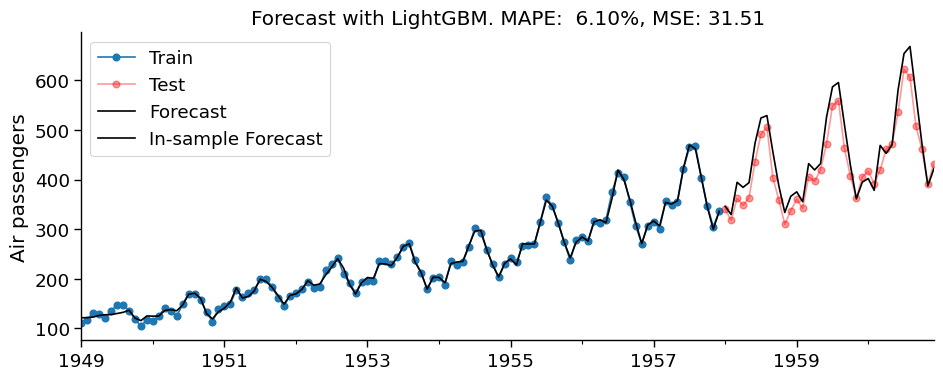

In [28]:
fig, ax = plt.subplots(figsize=[11, 4])

# Plot train/test data
y_train.loc[:forecast_start_time].plot(ax=ax, marker="o")
y_test.plot(ax=ax, marker="o", color="r", alpha=0.4)

# Plot Forecast
y_forecast.plot(ax=ax, color="k", linestyle="-")
y_forecast_train.plot(ax=ax, color="k", linestyle="-")

ax.set_title(f"Forecast with LightGBM. MAPE: {mape: .2%}, MSE: {mse:.2f}")
ax.legend(["Train", "Test", "Forecast", "In-sample Forecast"])
ax.set_xlabel("")
ax.set_ylabel(f"Air passengers")

plt.show()

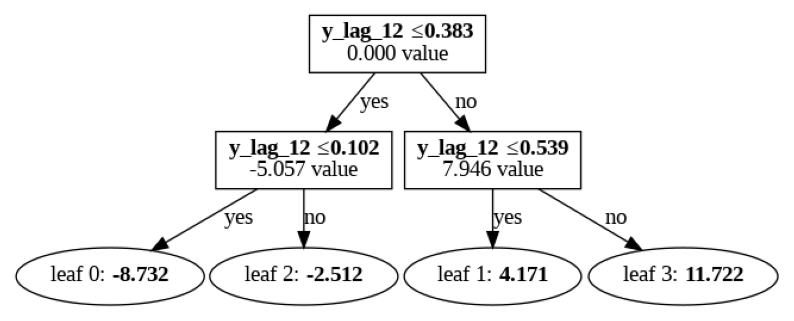

In [30]:
plot_tree(model,
    tree_index=1,
    figsize=(10,5),
    orientation="vertical",
    show_info="internal_value"
)

plt.show()